## Using boxcar filters, characterize variability within bands

In [1]:
%%time
import numpy as np
from matplotlib import colormaps as mplcm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import pandas as pd
from Tools import commonfxns as cf, OAPBuoyData as OAP, mplRC, OAPBuoyComp as bc,viz, evalfxns as ev, frequencyBands as fb
import netCDF4 as nc
import cftime
import datetime as dt
import cmocean
#import gsw
#from sklearn.linear_model import TheilSenRegressor
import pickle
import os
#from IPython.display import Markdown, display, HTML
#import astropy.timeseries as apt
from collections import OrderedDict
import warnings
from matplotlib.colors import ListedColormap
pd.set_option('display.max_rows', None)
mplRC.paperRC2();

CPU times: user 1.97 s, sys: 1.68 s, total: 3.65 s
Wall time: 3.47 s


In [2]:
dfInfoBuoy=OAP.loadOAPInfo(modMeans=True)
compsdir='/work/ebo/calcs/buoyCompTS/presentday/comps/'
#comps=bc.loadAllComps()
#statsdf=bc.loadStats(merged=True)

In [3]:
Tvec=[7,31,365]
freq='daily'

In [4]:
df=pd.read_csv(fb.bxfbase+f"bxf_df.{'_'.join([str(el) for el in Tvec])}.{freq}.csv")

In [5]:
df.keys()

Index(['Unnamed: 0', 'ivar', 'datasetID', 'var_1_7_obs', 'var_7_31_obs',
       'var_31_365_obs', 'var_g365_obs', 'var_total_obs', 'vards_1_7_obs',
       'vards_7_31_obs', 'vards_31_365_obs', 'vards_g365_obs',
       'vards_total_obs', 'var_seas_obs', 'var_b_seas_obs', 'var_b_1_7_obs',
       'var_b_7_31_obs', 'var_b_31_365_obs', 'var_b_g365_obs',
       'var_b_total_obs', 'vards_b_1_7_obs', 'vards_b_7_31_obs',
       'vards_b_31_365_obs', 'vards_b_g365_obs', 'vards_b_total_obs',
       'var_1_7_mod', 'var_7_31_mod', 'var_31_365_mod', 'var_g365_mod',
       'var_total_mod', 'vards_1_7_mod', 'vards_7_31_mod', 'vards_31_365_mod',
       'vards_g365_mod', 'vards_total_mod', 'var_seas_mod', 'var_1_7_obs_N',
       'var_7_31_obs_N', 'var_31_365_obs_N', 'var_g365_obs_N',
       'var_total_obs_N', 'vards_1_7_obs_N', 'vards_7_31_obs_N',
       'vards_31_365_obs_N', 'vards_g365_obs_N', 'vards_total_obs_N',
       'var_seas_obs_N', 'var_b_seas_obs_N', 'var_b_1_7_obs_N',
       'var_b_7_31_obs_N

### find station with max number of low frequency points for each variable

In [6]:
df2=df.loc[:,['ivar','var_g365_obs_N']].groupby(by='ivar').max().reset_index()

In [7]:
df.loc[df.ivar=='phos',['shortTitle','ivar','var_g365_obs_N']].sort_values(by='var_g365_obs_N',ascending=False)

,shortTitle,ivar,var_g365_obs_N
267,Papa,phos,2823
17,Gulf of Maine,phos,2030
169,CCE2,phos,1716
128,La Parguera,phos,1300
62,Gray's Reef,phos,1215
297,KEO,phos,1181
2,Iceland,phos,0
199,NH-10,phos,0
327,Kaneohe,phos,0
312,MOSEAN/WHOTS,phos,0


In [8]:
dftemp=df.loc[df.ivar=='phosC',['shortTitle','ivar','var_g365_obs_N']].sort_values(by='var_g365_obs_N',ascending=False)
dftemp

,shortTitle,ivar,var_g365_obs_N
271,Papa,phosC,4102
317,MOSEAN/WHOTS,phosC,3966
302,KEO,phosC,3857
22,Gulf of Maine,phosC,3727
174,CCE2,phosC,3712
118,Stratus,phosC,3620
159,CCE1,phosC,3263
415,TAO125W,phosC,3174
67,Gray's Reef,phosC,2601
216,Cape Elizabeth,phosC,2477


In [9]:
dfcp=dftemp.loc[dftemp.var_g365_obs_N>0,['shortTitle','var_g365_obs_N']].copy(deep=True)
dfct=df.loc[df.ivar=='tos',['shortTitle','var_g365_obs_N']]
dfcollect=dfcp.merge(dfct,how='inner',on='shortTitle',suffixes=('_phc','_sst'))
stalist=list(np.squeeze(dftemp.loc[dftemp.var_g365_obs_N>0,['shortTitle']].values))
stalist

['Papa',
 'MOSEAN/WHOTS',
 'KEO',
 'Gulf of Maine',
 'CCE2',
 'Stratus',
 'CCE1',
 'TAO125W',
 "Gray's Reef",
 'Cape Elizabeth',
 'TAO140W',
 'TAO170W',
 'SOFS',
 'TAO110W',
 'Cha ba',
 'Coastal MS',
 'TAO165E',
 'TAO155W',
 'Kodiak']

In [10]:
df.loc[df.ivar=='o2os',['shortTitle','ivar','var_g365_obs_N']].sort_values(by='var_g365_obs_N',ascending=False)

,shortTitle,ivar,var_g365_obs_N
171,CCE2,o2os,2850
19,Gulf of Maine,o2os,2647
156,CCE1,o2os,1744
64,Gray's Reef,o2os,1327
226,Cha ba,o2os,1323
104,Cheeca Rocks,o2os,1258
314,MOSEAN/WHOTS,o2os,1211
186,Cape Arago,o2os,0
329,Kaneohe,o2os,0
299,KEO,o2os,0


In [11]:
df3=df2.merge(df,on=['ivar','var_g365_obs_N'],).loc[:,['ivar','var_g365_obs_N','datasetID','shortTitle']]
df3

,ivar,var_g365_obs_N,datasetID,shortTitle
0,AOUos,2846,pmel_co2_moorings_9675_b3d3_c1c1,CCE2
1,apco2,4110,pmel_co2_moorings_9bc0_7e75_7ae7,MOSEAN/WHOTS
2,chlos,2853,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine
3,co2dryair,4291,pmel_co2_moorings_cba8_5413_09f9,Papa
4,dissicos,4102,pmel_co2_moorings_cba8_5413_09f9,Papa
5,l10chlos,2853,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine
6,o2os,2850,pmel_co2_moorings_9675_b3d3_c1c1,CCE2
7,o2percos,2846,pmel_co2_moorings_9675_b3d3_c1c1,CCE2
8,omega_a_0,4102,pmel_co2_moorings_cba8_5413_09f9,Papa
9,phos,2823,pmel_co2_moorings_cba8_5413_09f9,Papa


In [12]:
df.loc[df.shortTitle.isin(['CCE1','Gulf of Maine','Papa','MOSEAN/WHOTS','KEO']),
       ['datasetID','shortTitle','ivar','var_g365_obs_N',]]

,datasetID,shortTitle,ivar,var_g365_obs_N
15,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,tos,3749
16,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,sos,4141
17,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,phos,2030
18,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,spco2,4127
19,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,o2os,2647
20,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,chlos,2853
21,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,l10chlos,2853
22,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,phosC,3727
23,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,talkos,4141
24,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,omega_a_0,3727


Create plots for Papa because it has the most low freuqency pH and pCO2 points, CCE2 because it is coastal and has T, S, and pCO2, and Gulf of Maine because it is coastal and has the most low-frequency oxygen data. 

#### Papa and Gulf of Maine

In [13]:
# use deaseasonalized values so that all analyses are relative to monthly climatology

In [14]:
def makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=False):
    if reverse==True: # sign switch
        rfac=-1
    else:
        rfac=1
    xvar=rfac*xvar
    yvar=rfac*yvar
    qx33=np.nanpercentile(xvar,100/3)
    qx67=np.nanpercentile(xvar,100*2/3)
    qy90=np.nanpercentile(yvar,90)
    i90=yvar>qy90

    ilow=xvar<=qx33
    imed=(xvar>qx33)&(xvar<qx67)
    ihi=xvar>=qx67

    p90low=np.sum(i90&ilow)/np.sum(ilow+imed+ihi)
    p90med=np.sum(i90&imed)/np.sum(ilow+imed+ihi)
    p90hi=np.sum(i90&ihi)/np.sum(ilow+imed+ihi)
    # switch sign back
    xvar=rfac*xvar
    yvar=rfac*yvar
    iax.plot(xvar,yvar,'k.',alpha=.1,ms=2)
    iax.axhline(rfac*qy90,color='blue')
    iax.axvline(rfac*qx33,color='r')
    iax.axvline(rfac*qx67,color='r')
    iax.set_xlabel(xlab)
    iax.set_ylabel(ylab)
    
#     ax[1].legend([f'low (P$_9$$_0$={p90low:.2f})',f'medium (P$_9$$_0$={p90med:.2f})',
#                   f'high (P$_9$$_0$={p90hi:.2f})'],fontsize=10)

    return rfac*qx33,rfac*qx67,rfac*qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi

In [15]:
icomps=dict()
icomps[('Papa','tos')]=bc.loadMoorComp(OAP.getID('Papa'),'tos',path=compsdir)
icomps[('Papa','phos')]=bc.loadMoorComp(OAP.getID('Papa'),'phos',path=compsdir)
icomps[('Papa','phosC')]=bc.loadMoorComp(OAP.getID('Papa'),'phosC',path=compsdir)

icomps[('GOM','tos')]=bc.loadMoorComp(OAP.getID('Maine'),'tos',path=compsdir)
icomps[('GOM','phos')]=bc.loadMoorComp(OAP.getID('Maine'),'phos',path=compsdir)
icomps[('GOM','phosC')]=bc.loadMoorComp(OAP.getID('Maine'),'phosC',path=compsdir)

icomps[('KEO','tos')]=bc.loadMoorComp(OAP.getID('KEO'),'tos',path=compsdir)
icomps[('KEO','phos')]=bc.loadMoorComp(OAP.getID('KEO'),'phos',path=compsdir)
icomps[('KEO','phosC')]=bc.loadMoorComp(OAP.getID('KEO'),'phosC',path=compsdir)

icomps[('WHOTS','tos')]=bc.loadMoorComp(OAP.getID('WHOTS'),'tos',path=compsdir)
icomps[('WHOTS','phosC')]=bc.loadMoorComp(OAP.getID('WHOTS'),'phosC',path=compsdir)
icomps[('BTM','tos')]=bc.loadMoorComp(OAP.getID('BTM'),'tos',path=compsdir)
icomps[('BTM','phosC')]=bc.loadMoorComp(OAP.getID('BTM'),'phosC',path=compsdir)

def quickloadbxf(dsid,ivar):
    ppath=fb.bxfpath(dsid,ivar,Tvec,freq,fb.bxfbase)
    with open(ppath, 'rb') as hh:
        bxf=pickle.load(hh)
    return bxf
bxfs=dict()
bxfs[('Papa','tos')]=quickloadbxf(OAP.getID('Papa'),'tos')
bxfs[('Papa','phos')]=quickloadbxf(OAP.getID('Papa'),'phos')
bxfs[('Papa','phosC')]=quickloadbxf(OAP.getID('Papa'),'phosC')
bxfs[('GOM','tos')]=quickloadbxf(OAP.getID('Maine'),'tos')
bxfs[('GOM','phos')]=quickloadbxf(OAP.getID('Maine'),'phos')
bxfs[('GOM','phosC')]=quickloadbxf(OAP.getID('Maine'),'phosC')
bxfs[('KEO','tos')]=quickloadbxf(OAP.getID('KEO'),'tos')
bxfs[('KEO','phos')]=quickloadbxf(OAP.getID('KEO'),'phos')
bxfs[('KEO','phosC')]=quickloadbxf(OAP.getID('KEO'),'phosC')
bxfs[('WHOTS','tos')]=quickloadbxf(OAP.getID('WHOTS'),'tos')
bxfs[('WHOTS','phosC')]=quickloadbxf(OAP.getID('WHOTS'),'phosC')
bxfs[('BTM','tos')]=quickloadbxf(OAP.getID('BTM'),'tos')
bxfs[('BTM','phosC')]=quickloadbxf(OAP.getID('BTM'),'phosC')

In [16]:
bxfs[('Papa','tos')]['oval']

{'full': array([-0.87265565, -0.88108751, -1.02700351, ..., -1.72879376,
        -1.69570975, -1.58126427]),
 'deseas': array([-0.40749866, -0.47916926, -0.68797596, ..., -0.22369824,
        -0.25382041, -0.20335117])}

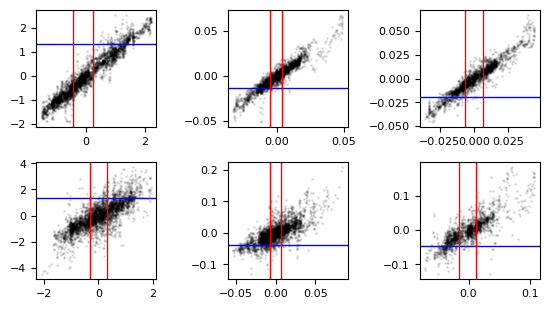

In [17]:
fig,ax=plt.subplots(2,3,figsize=(6.5,3.5),gridspec_kw={'hspace':.3,'wspace':.6})

icomp=icomps[('Papa','tos')]
bxf=bxfs[('Papa','tos')]
iax=ax[0,0]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1]);#bxf['bando']['deseas'][3] # previously only longer than annual
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab=""#Anomaly in Low\nFrequency Component"
ylab=("")#Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp)

icomp=icomps[('Papa','phosC')]
bxf=bxfs[('Papa','phosC')]
iax=ax[0,1]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab=""#Anomaly in Low\nFrequency Component"
ylab=("")#Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=True)


icomp=icomps[('Papa','phos')]
bxf=bxfs[('Papa','phos')]
iax=ax[0,2]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab=""#Anomaly in Low\nFrequency Component"
ylab=("")#Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=True)

icomp=icomps[('GOM','tos')]
bxf=bxfs[('GOM','tos')]
iax=ax[1,0]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab=""#Anomaly in Low\nFrequency Component"
ylab=("")#Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp)

icomp=icomps[('GOM','phosC')]
bxf=bxfs[('GOM','phosC')]
iax=ax[1,1]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab=""#Anomaly in Low\nFrequency Component"
ylab=("")#Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=True)


icomp=icomps[('GOM','phos')]
bxf=bxfs[('GOM','phos')]
iax=ax[1,2]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab=""#Anomaly in Low\nFrequency Component"
ylab=("")#Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=True)


Text(0.5, 1.0, 'Papa phos and phosC')

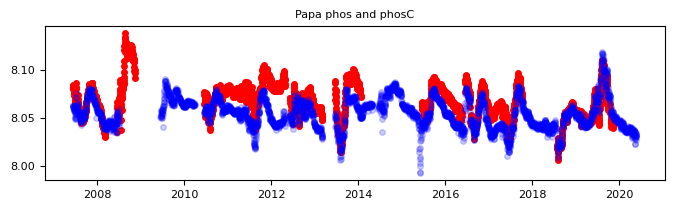

In [18]:
fig,ax=plt.subplots(1,1,figsize=(8,2))
ic1=icomps[('Papa','phos')]
ic2=icomps[('Papa','phosC')]
ax.plot(ic1.obs_tdt,ic1.obs_val,'r.')
ax.plot(ic2.obs_tdt,ic2.obs_val,'b.',alpha=.2)
ax.set_title('Papa phos and phosC')

Text(0.5, 1.0, 'Gulf of Maine phos and phosC')

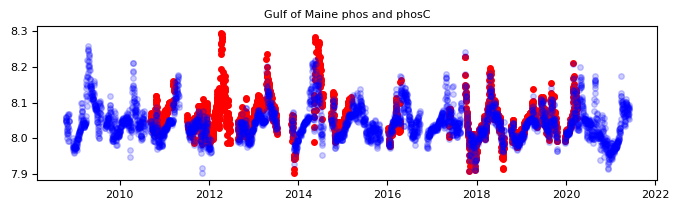

In [19]:
fig,ax=plt.subplots(1,1,figsize=(8,2))
ic1=icomps[('GOM','phos')]
ic2=icomps[('GOM','phosC')]
ax.plot(ic1.obs_tdt,ic1.obs_val,'r.')
ax.plot(ic2.obs_tdt,ic2.obs_val,'b.',alpha=.2)
ax.set_title('Gulf of Maine phos and phosC')

Text(0.5, 1.0, 'KEO phos and phosC')

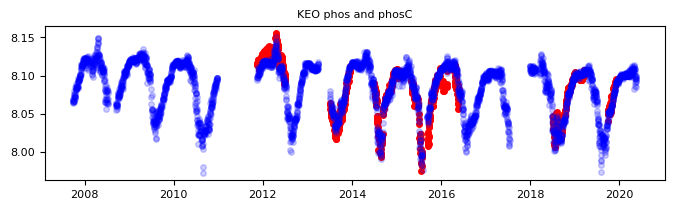

In [20]:
fig,ax=plt.subplots(1,1,figsize=(8,2))
ic1=icomps[('KEO','phos')]
ic2=icomps[('KEO','phosC')]
ax.plot(ic1.obs_tdt,ic1.obs_val,'r.')
ax.plot(ic2.obs_tdt,ic2.obs_val,'b.',alpha=.2)
ax.set_title('KEO phos and phosC')

### new plan: KEO and GOM, use calculated ph (phosC)

In [21]:
def _shadeT(iax,qx67,qy90):
    xlims=iax.get_xlim()
    ylims=iax.get_ylim()
    print(xlims,ylims)
    iax.fill_between([qx67,xlims[1],],qy90,ylims[1],color='yellow',alpha=.1,zorder=0)
    iax.set_xlim(xlims)
    iax.set_ylim(ylims)
    return
def _shadePH(iax,qx67,qy10):
    xlims=iax.get_xlim()
    ylims=iax.get_ylim()
    print(xlims,ylims)
    iax.fill_between([qx67,xlims[0],],qy10,ylims[0],color='yellow',alpha=.1,zorder=0)
    iax.set_xlim(xlims)
    iax.set_ylim(ylims)
    return

(-1.6561522959074482, 1.3327102714853323) (-6.566489476104108, 2.8252581280212627)
(-0.038568042617018954, 0.022943406685567776) (-0.0690536355642605, 0.03744383796663192)
(-2.2947414370376773, 2.1227671142755846) (-4.86587484533434, 4.091061483558289)
(-0.0602541408580642, 0.09116360486252316) (-0.14735192556134985, 0.2244053748403519)


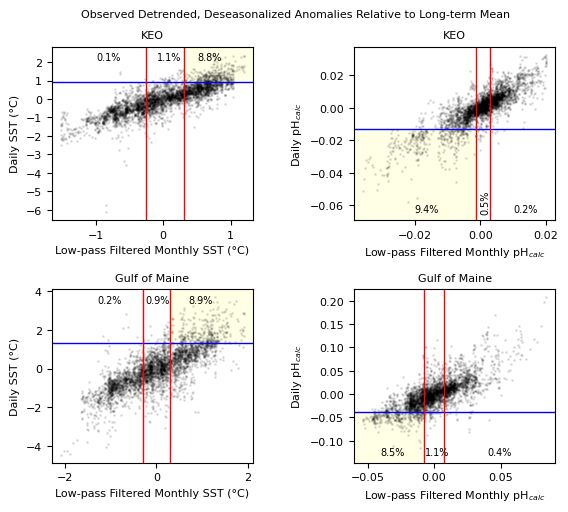

In [22]:
fig,ax=plt.subplots(2,2,figsize=(6.5,5.4),gridspec_kw={'hspace':.4,'wspace':.5})
fs=7
icomp=icomps[('KEO','tos')]
bxf=bxfs[('KEO','tos')]
iax=ax[0,0]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab="Low Frequency Component"
ylab=("Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp)
iax.text(-1.0,2.1,f"{p90low*100:.1f}%",fontsize=fs)
iax.text(-.1,2.1,f"{p90med*100:.1f}%",fontsize=fs)
iax.text(.5,2.1,f"{p90hi*100:.1f}%",fontsize=fs)
_shadeT(iax,qx67,qy90)

icomp=icomps[('KEO','phosC')]
bxf=bxfs[('KEO','phosC')]
iax=ax[0,1]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab="Low Frequency Component"
ylab=("Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=True)
# need to reverse order because for pH, high is really low
ax[0,1].text(-.02,-.064,f"{p90hi*100:.1f}%",fontsize=fs)
ax[0,1].text(0,-.064,f"{p90med*100:.1f}%",fontsize=fs,rotation=90)
ax[0,1].text(.01,-.064,f"{p90low*100:.1f}%",fontsize=fs)
_shadePH(iax,qx67,qy90)

icomp=icomps[('GOM','tos')]
bxf=bxfs[('GOM','tos')]
iax=ax[1,0]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab="Low Frequency Component"
ylab=("Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp)
ax[1,0].text(-1.3,3.4,f"{p90low*100:.1f}%",fontsize=fs)
ax[1,0].text(-.25,3.4,f"{p90med*100:.1f}%",fontsize=fs)
ax[1,0].text(.7,3.4,f"{p90hi*100:.1f}%",fontsize=fs)
_shadeT(iax,qx67,qy90)

icomp=icomps[('GOM','phosC')]
bxf=bxfs[('GOM','phosC')]
iax=ax[1,1]
xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
ix=~np.isnan(xvar)
yvar=bxf['oval']['deseas']
xvar=xvar[ix]-np.nanmean(xvar[ix])
yvar=yvar[ix]-np.nanmean(yvar[ix])
xlab="Low Frequency Component"
ylab=("Detrended, Deseasonalized\nDaily Anomaly")
qx33,qx67,qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi = makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=True)
ax[1,1].text(-.04, -.13,f"{p90hi*100:.1f}%",fontsize=fs)
ax[1,1].text(-0.007,-.13,f"{p90med*100:.1f}%",fontsize=fs)
ax[1,1].text(.04,  -.13,f"{p90low*100:.1f}%",fontsize=fs)
ax[1,1].set_xticks([-.04,0,.04,.08])
_shadePH(iax,qx67,qy90)

ax[0,0].set_title('KEO')
ax[0,1].set_title('KEO')
ax[1,0].set_title('Gulf of Maine')
ax[1,1].set_title('Gulf of Maine')

ax[0,0].set_xlabel('Low-pass Filtered Monthly SST (°C)')
ax[0,0].set_ylabel('Daily SST (°C)')
ax[0,1].set_xlabel('Low-pass Filtered Monthly pH$_{calc}$')
ax[0,1].set_ylabel('Daily pH$_{calc}$')
ax[1,0].set_xlabel('Low-pass Filtered Monthly SST (°C)')
ax[1,0].set_ylabel('Daily SST (°C)')
ax[1,1].set_xlabel('Low-pass Filtered Monthly pH$_{calc}$')
ax[1,1].set_ylabel('Daily pH$_{calc}$')

ax[0,0].set_xticks([-1,0,1])
ax[0,0].set_yticks(np.arange(-6,3))
ax[0,1].set_xticks([-0.02,0,0.02])
ax[0,1].set_yticks(np.arange(-0.06,0.03,0.02))
ax[1,0].set_xticks([-2,0,2])
ax[1,0].set_yticks(np.arange(-4,5,2))
ax[1,1].set_xticks([-0.05,0,0.05])
ax[1,1].set_yticks(np.arange(-0.1,.25,0.05))

fig.suptitle('Observed Detrended, Deseasonalized Anomalies Relative to Long-term Mean',y=.95)

fig.savefig('/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly.pdf',dpi=400,bbox_inches='tight')
fig.savefig('/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly.tif',dpi=400,bbox_inches='tight')

In [23]:
ax[0,0].get_ylim()

(-6.566489476104108, 2.8252581280212627)

In [24]:
def makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=False):
    if reverse==True: # sign switch
        rfac=-1
    else:
        rfac=1
    xvar=rfac*xvar
    yvar=rfac*yvar
    qx33=np.nanpercentile(xvar,100/3)
    qx67=np.nanpercentile(xvar,100*2/3)
    qy90=np.nanpercentile(yvar,90)
    i90=yvar>qy90
    ilow=xvar<=qx33
    imed=(xvar>qx33)&(xvar<qx67)
    ihi=xvar>=qx67
    p90low=np.sum(i90&ilow)/np.sum(ilow+imed+ihi)
    p90med=np.sum(i90&imed)/np.sum(ilow+imed+ihi)
    p90hi=np.sum(i90&ihi)/np.sum(ilow+imed+ihi)
    # switch sign back
    xvar=rfac*xvar
    yvar=rfac*yvar
    iax.plot(xvar,yvar,'k.',alpha=.1,ms=2)
    iax.axhline(rfac*qy90,color='blue')
    iax.axvline(rfac*qx33,color='r')
    iax.axvline(rfac*qx67,color='r')
    iax.set_xlabel(xlab)
    iax.set_ylabel(ylab)
    [x0,x1]=iax.get_xlim()
    [y0,y1]=iax.get_ylim()
    if reverse:
        iax.text(.5*(x0+-1*qx67),y0+.03*(y1-y0),f"{p90hi*100:.1f}%",fontsize=fs,ha='center')
        iax.text(-1*.5*(qx33+qx67),y0+.03*(y1-y0),f"{p90med*100:.1f}%",fontsize=fs,ha='center')
        iax.text(.5*(-1*qx33+x1),y0+.03*(y1-y0),f"{p90low*100:.1f}%",fontsize=fs,ha='center')
        iax.fill_between([rfac*qx67,x0],rfac*qy90,y0,color='yellow',alpha=.1,zorder=0)
    else:
        iax.text(.5*(x0+qx33),y0+.93*(y1-y0),f"{p90low*100:.1f}%",fontsize=fs,ha='center')
        iax.text(.5*(qx33+qx67),y0+.93*(y1-y0),f"{p90med*100:.1f}%",fontsize=fs,ha='center')
        iax.text(.5*(qx67+x1),y0+.93*(y1-y0),f"{p90hi*100:.1f}%",fontsize=fs,ha='center')
        iax.fill_between([qx67,x1],qy90,y1,color='yellow',alpha=.1,zorder=0)
    iax.set_xlim(x0,x1)
    iax.set_ylim(y0,y1)
    return rfac*qx33,rfac*qx67,rfac*qy90,i90,ilow,imed,ihi,p90low,p90med,p90hi

def _fmt(stra):
    return stra.replace("'","").replace(' ',"").replace('/',"")
def makerow(shortName):
    fig,ax=plt.subplots(1,2,figsize=(6,2.1),gridspec_kw={'hspace':.4,'wspace':.5})
    ax=np.expand_dims(ax,axis=0)
    fs=7
    icomp=icomps[(shortName,'tos')]
    bxf=bxfs[(shortName,'tos')]
    iax=ax[0,0]
    xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
    ix=~np.isnan(xvar)
    yvar=bxf['oval']['deseas']
    xvar=xvar[ix]-np.nanmean(xvar[ix])
    yvar=yvar[ix]-np.nanmean(yvar[ix])
    xlab="Low Frequency Component"
    ylab=("Detrended, Deseasonalized\nDaily Anomaly")
    qx33_tos,qx67_tos,qy90_tos,i90_tos,ilow_tos,imed_tos,ihi_tos,p90low_tos,p90med_tos,p90hi_tos = \
            makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp)
    varx_T=np.var(xvar)
    vary_T=np.var(yvar)

    icomp=icomps[(shortName,'phosC')]
    bxf=bxfs[(shortName,'phosC')]
    iax=ax[0,1]
    xvar=np.squeeze(bxf['bxfilto']['deseas'][1])
    ix=~np.isnan(xvar)
    yvar=bxf['oval']['deseas']
    xvar=xvar[ix]-np.nanmean(xvar[ix])
    yvar=yvar[ix]-np.nanmean(yvar[ix])
    xlab="Low Frequency Component"
    ylab=("Detrended, Deseasonalized\nDaily Anomaly")
    qx33_phosC,qx67_phosC,qy90_phosC,i90_phosC,ilow_phosC,imed_phosC,ihi_phosC,p90low_phosC,p90med_phosC,p90hi_phosC = \
            makeHiLowPlots(iax,xvar,yvar,xlab,ylab,icomp,reverse=True)
    varx_pH=np.var(xvar)
    vary_pH=np.var(yvar)

    ax[0,0].set_title(shortName+' SST (°C)')
    ax[0,1].set_title(shortName+' pH$_{calc}$')

    fig.savefig(f'/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_{_fmt(shortName)}.png',dpi=400,bbox_inches='tight')
    print(f'/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_{_fmt(shortName)}.png')
    return fig,ax,p90low_tos,p90med_tos,p90hi_tos,p90low_phosC,p90med_phosC,p90hi_phosC,varx_T,vary_T,varx_pH,vary_pH

In [25]:
icomps=dict()
bxfs=dict()

for sta in stalist:
    for ivar in ['tos','phosC','phos']:
        try:
            icomps[(sta,ivar)]=bc.loadMoorComp(OAP.getID(sta),ivar,path=compsdir)
            bxfs[(sta,ivar)]=quickloadbxf(OAP.getID(sta),ivar)
        except:
            print(f'no files for {sta} {ivar}')

no files for TAO125W phos
no files for TAO140W phos
no files for TAO170W phos
no files for SOFS phos
no files for TAO110W phos
no files for TAO165E phos
no files for TAO155W phos
no files for Kodiak phos


In [26]:
dfcollect[['p90low_sst','p90med_sst','p90high_sst','p90low_phc','p90med_phc','p90high_phc','varx_T','vary_T','varx_pH','vary_pH','Rcalcsens','N_R']]=np.nan
#dfcollect

/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_Papa.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_MOSEANWHOTS.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_KEO.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_GulfofMaine.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_CCE2.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_Stratus.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_CCE1.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_TAO125W.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_GraysReef.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_CapeElizabeth.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_TAO140W.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_TAO170W.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_SOFS.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_TAO110W.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Rev_Monthly_Chaba.png
/home/Elise.Olson/OAPMSE/paperFigs/lohi_Re

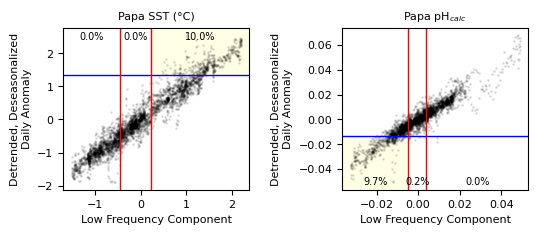

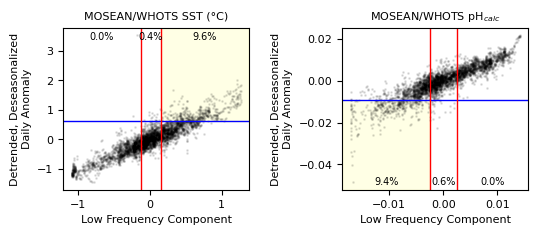

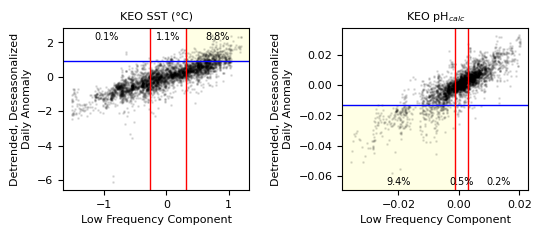

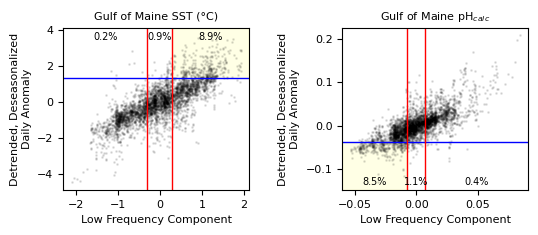

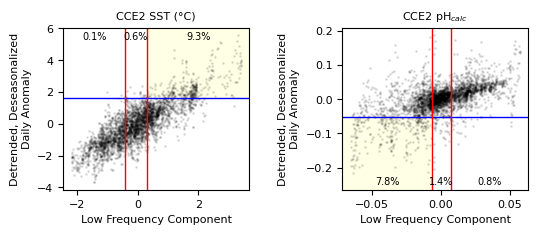

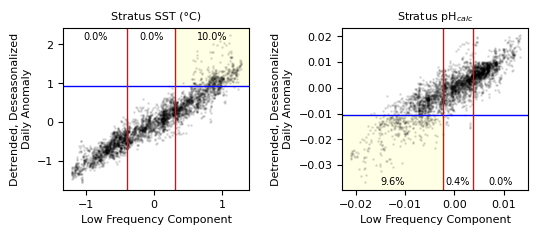

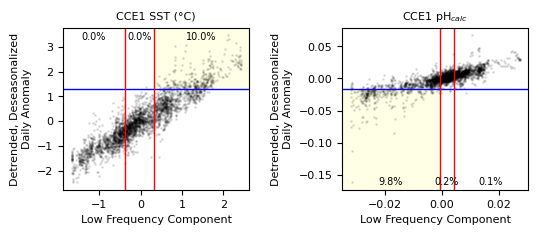

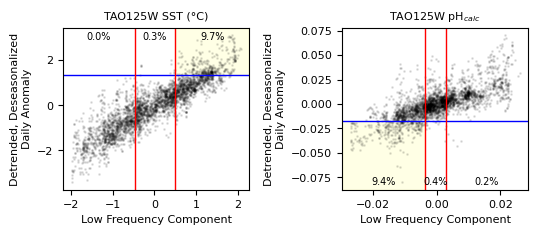

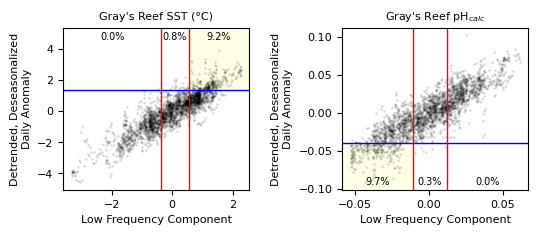

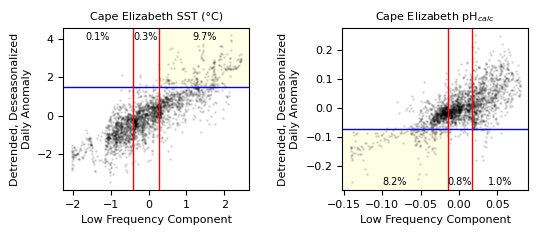

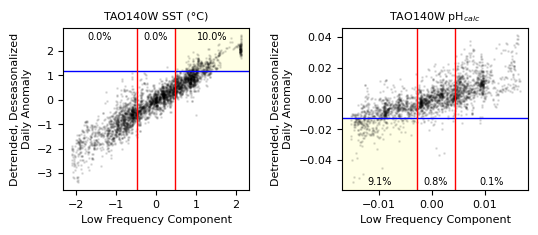

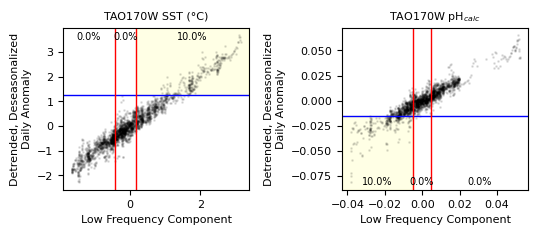

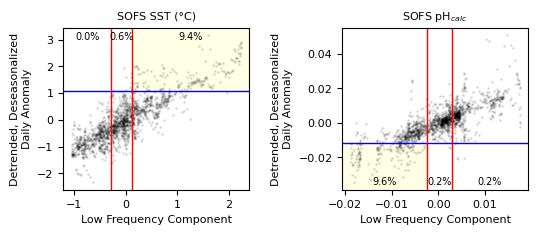

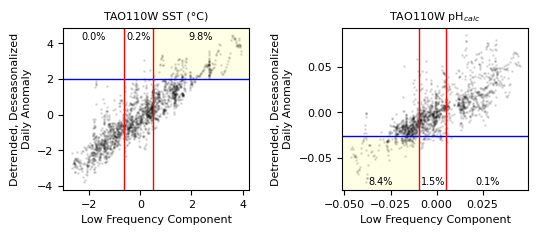

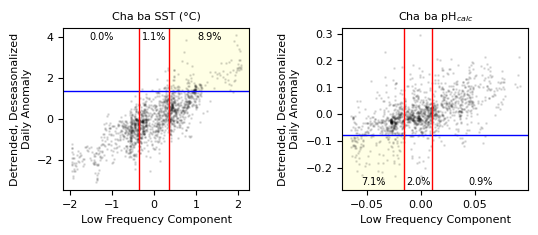

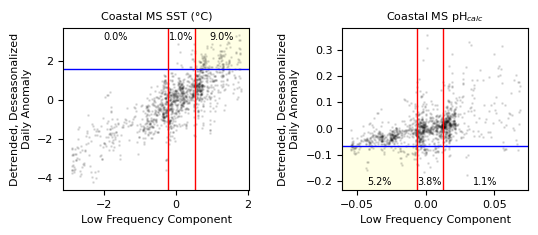

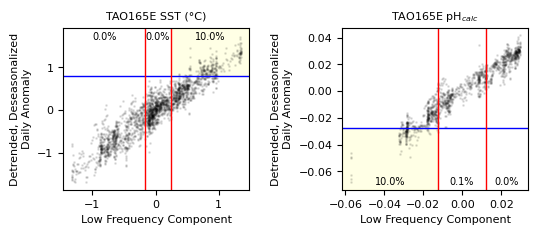

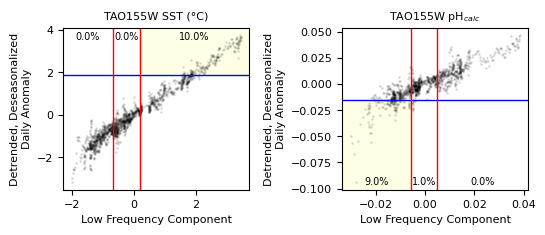

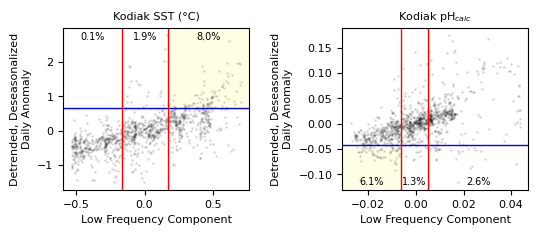

In [27]:
for sta in stalist:
    fig,ax,p90low_tos,p90med_tos,p90hi_tos,p90low_phosC,p90med_phosC,p90hi_phosC,varx_T,vary_T,varx_pH,vary_pH=makerow(sta)
    dfcollect.loc[(dfcollect.shortTitle==sta),
                  ['p90low_sst','p90med_sst','p90high_sst','p90low_phc','p90med_phc','p90high_phc','varx_T','vary_T','varx_pH','vary_pH']]=\
                                        [p90low_tos,p90med_tos,p90hi_tos,p90low_phosC,p90med_phosC,p90hi_phosC,varx_T,vary_T,varx_pH,vary_pH]

In [28]:
sta='TAO140W'
ic1=icomps[(sta,'phos')]
ic1.obs_val

array([nan])

In [29]:
for sta in stalist:
    try:
        ic1=icomps[(sta,'phos')]
        ic2=icomps[(sta,'phosC')]
    except:
        print('no data:',sta)
    else:
        if len(ic1.obs_val)>1:
            df1=pd.DataFrame(np.array([ic1.obs_tdt,ic1.obs_val]).T,columns=['tdt','pH'])
            df2=pd.DataFrame(np.array([ic2.obs_tdt,ic2.obs_val]).T,columns=['tdt','pHc'])
            dfc=df1.merge(df2,on='tdt')
            R=np.corrcoef(dfc.pH.values.astype(float),dfc.pHc.values.astype(float))[0,1]
            N_r=len(dfc)
            dfcollect.loc[(dfcollect.shortTitle==sta),
                      ['Rcalcsens','N_R']]=[R,N_r]
        else:
            print('no data:',sta)

no data: TAO125W
no data: TAO140W
no data: TAO170W
no data: SOFS
no data: TAO110W
no data: TAO165E
no data: TAO155W
no data: Kodiak


In [30]:
dfcollect

,shortTitle,var_g365_obs_N_phc,var_g365_obs_N_sst,p90low_sst,p90med_sst,p90high_sst,p90low_phc,p90med_phc,p90high_phc,varx_T,vary_T,varx_pH,vary_pH,Rcalcsens,N_R
0,Papa,4102,4153,0.000000,0.000000,0.100169,0.000488,0.002438,0.097270,0.708042,0.821770,0.000128,0.000164,0.759691,2690.0
1,MOSEAN/WHOTS,3966,4118,0.000486,0.003885,0.095678,0.000000,0.006304,0.093797,0.182774,0.258274,0.000035,0.000051,0.837994,449.0
2,KEO,3857,4081,0.000735,0.011027,0.088214,0.001556,0.004667,0.093855,0.305642,0.573269,0.000062,0.000109,0.967853,1180.0
3,Gulf of Maine,3727,3749,0.001600,0.009069,0.089357,0.004293,0.011269,0.084518,0.505337,1.094435,0.000352,0.000998,0.896980,1858.0
4,CCE2,3712,3721,0.001075,0.005644,0.093255,0.007543,0.014278,0.078394,0.951917,1.607430,0.000489,0.001995,0.897223,1674.0
5,Stratus,3620,3821,0.000000,0.000000,0.099974,0.000000,0.003591,0.096409,0.367515,0.442860,0.000041,0.000065,0.717788,290.0
6,CCE1,3263,3276,0.000000,0.000305,0.099817,0.000613,0.001839,0.097763,0.679077,0.878864,0.000105,0.000180,-0.224221,776.0
7,TAO125W,3174,3519,0.000000,0.002842,0.097187,0.001575,0.004411,0.094203,0.842461,1.174779,0.000094,0.000233,NaN,NaN
8,Gray's Reef,2601,2893,0.000346,0.007605,0.092292,0.000000,0.002691,0.097270,0.898566,1.426300,0.000568,0.000894,0.969340,946.0
9,Cape Elizabeth,2477,2535,0.000789,0.002761,0.096647,0.010093,0.007671,0.082358,0.760960,1.359156,0.001327,0.003835,0.970074,182.0


In [31]:
# write tex file
lines=[]# list of lines in table
lines.append(r"""\setlength\tabcolsep{4pt} % default value: 6pt
    \begin{longtable}{p{1.4in}llllp{.1in}llllll}
    \caption{Fraction of total days that are classified as of 90\textsuperscript{th} percentile extreme days and fall into 
    each tercile (low, medium, or high) in terms of the low-pass filtered anomalies. 90\textsuperscript{th} percentile extremes
    are based on anomalies relative to the detrended, deseasonalized time series. N\textsubscript{Filt} is 
    the length in days of the low-pass filtered series. R\textsubscript{pH} is the 
    Pearson correlation coefficient between calculated and sensed pH, where available, and N\textsubscript{R} 
    is the number of days included in the correlation calculation. The high stress likelihood column corresponds 
    to the percent of points falling in the tinted region in Figure 8. }
    \label{tbl:hilow}\\
    \hline 
    """)
lines.append(r' \multicolumn{1}{l}{Mooring} & \multicolumn{3}{c}{High SST Stress} & & & \multicolumn{3}{c}{Low \calcpH{} Stress} & & & \\'
             '  \cline{2-4}\cline{7-9}'+'\n')
lines.append(r'Filtered Tercile: & Low & Med. & High & N\textsubscript{Filt} & & High & Med. & Low'
             r' & N\textsubscript{Filt} & R\textsubscript{pH} & N\textsubscript{R} \\'+'\n')
lines.append(r' Stress Likelihood: & Low & Med. & High &   & & Low & Med. & High'
             r' &   &   &   \\'+'\n')
lines.append(r'  \hline'+'\n')
lines.append(r'  \endhead'+'\n')
for ind, row in dfcollect.iterrows():
    if not pd.isnull(row.Rcalcsens):
        nr=int(row.N_R)
        rr=f'{row.Rcalcsens:.2f}'
    else:
        nr=' '
        rr=' '
    lines.append(f'  {row.shortTitle} & {100*row.p90low_sst:.1f} & {100*row.p90med_sst:.1f} & {100*row.p90high_sst:.1f} & {row.var_g365_obs_N_sst}'
                                 f' & & {100*row.p90low_phc:.1f} & {100*row.p90med_phc:.1f} & {100*row.p90high_phc:.1f} & {row.var_g365_obs_N_phc}'
                f' & {rr} & {nr}'+r' \\'+'\n')
lines.append(r'  \end{longtable}'+'\n')

f = open('/home/ebo/OAPMSE/paperFigs/TableLoHi_Monthly.tex', 'w')
f.writelines(lines)
f.close()

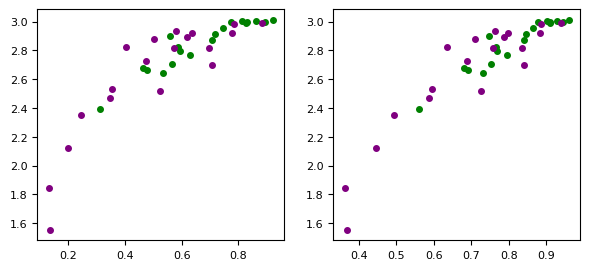

In [32]:
fig,ax=plt.subplots(1,2,figsize=(7,3))
ax[0].plot(dfcollect.varx_T/dfcollect.vary_T,dfcollect.p90high_sst/(.1/3),'g.')
ax[1].plot(np.sqrt(dfcollect.varx_T/dfcollect.vary_T),dfcollect.p90high_sst/(.1/3),'g.')
ax[0].plot(dfcollect.varx_pH/dfcollect.vary_pH,dfcollect.p90high_phc/(.1/3),'.',color='purple')
ax[1].plot(np.sqrt(dfcollect.varx_pH/dfcollect.vary_pH),dfcollect.p90high_phc/(.1/3),'.',color='purple')

Text(0, 0.5, 'pHcalc-pHsens')

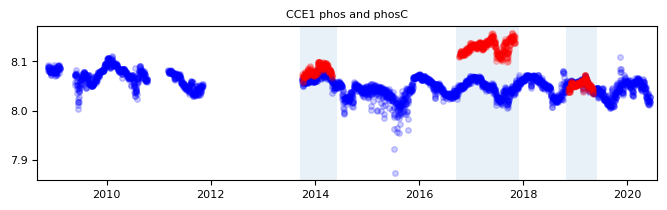

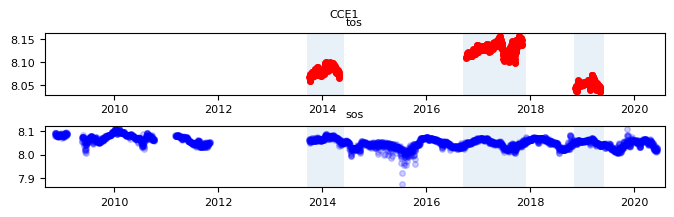

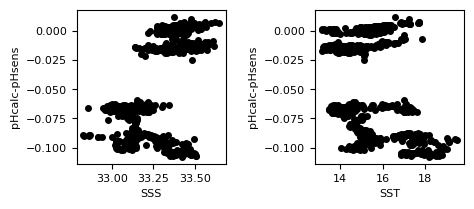

In [33]:
def _adhs(ax):
    ax.axvspan(dt.datetime(2013,9,15),dt.datetime(2014,6,1),alpha=.1)
    ax.axvspan(dt.datetime(2016,9,15),dt.datetime(2017,12,1),alpha=.1)
    ax.axvspan(dt.datetime(2018,11,1),dt.datetime(2019,6,1),alpha=.1)
    ax.set_xlim(dt.datetime(2008,9,1),dt.datetime(2020,8,1))
    return
fig,ax=plt.subplots(1,1,figsize=(8,2))
ic1=icomps[('CCE1','phos')]
ic2=icomps[('CCE1','phosC')]
#ax.plot(ic1.obs_tdt,ic1.obs_val,'r.',alpha=.2)
ax.plot(ic2.obs_tdt,ic2.obs_val,'b.',alpha=.2)
ax.plot(ic1.obs_tdt,ic1.obs_val,'r.',alpha=.2)
ax.set_title('CCE1 phos and phosC')
_adhs(ax)

fig,ax=plt.subplots(2,1,figsize=(8,2),gridspec_kw={'hspace':.5})
ic3=bc.loadMoorComp(OAP.getID('CCE1'),'tos',path=compsdir)
ic4=bc.loadMoorComp(OAP.getID('CCE1'),'sos',path=compsdir)
ax[0].plot(ic1.obs_tdt,ic1.obs_val,'r.')
ax[0].set_title('tos')
ax[1].plot(ic2.obs_tdt,ic2.obs_val,'b.',alpha=.2)
ax[1].set_title('sos')
fig.suptitle('CCE1',y=1)
_adhs(ax[0]);_adhs(ax[1])

dfphs=pd.DataFrame(np.array([ic1.obs_tdt,ic1.obs_val]).T,columns=['tdt','pH'])
dfphc=pd.DataFrame(np.array([ic2.obs_tdt,ic2.obs_val]).T,columns=['tdt','pHc'])
dfT=pd.DataFrame(np.array([ic3.obs_tdt,ic3.obs_val]).T,columns=['tdt','SST'])
dfS=pd.DataFrame(np.array([ic4.obs_tdt,ic4.obs_val]).T,columns=['tdt','SSS'])
dfc=dfphs.merge(dfphc,on='tdt').merge(dfT,on='tdt').merge(dfS,on='tdt')
fig,ax=plt.subplots(1,2,figsize=(5,2),gridspec_kw={'wspace':.6})
ax[0].plot(dfc.SSS,dfc.pHc-dfc.pH,'k.')
ax[0].set_xlabel('SSS');ax[0].set_ylabel('pHcalc-pHsens')
ax[1].plot(dfc.SST,dfc.pHc-dfc.pH,'k.')
ax[1].set_xlabel('SST');ax[1].set_ylabel('pHcalc-pHsens')

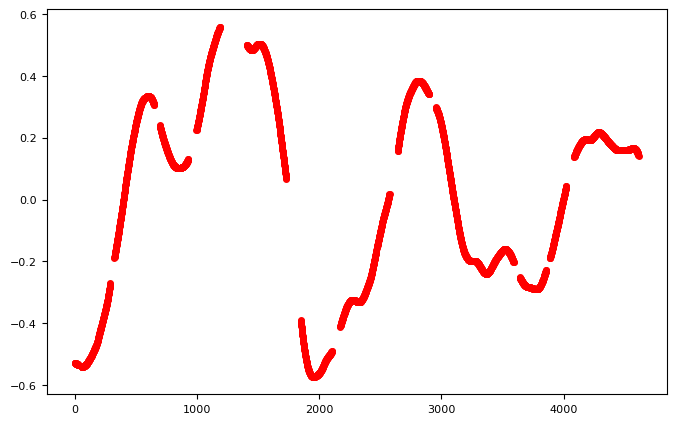

In [34]:
    bxf=bxfs[('Gulf of Maine','tos')]
    xvar=bxf['bando']['deseas'][3]
    plt.plot(xvar,'r.')

In [35]:
bxf['bando']['deseas']

{0: array([-0.02530686,  0.06361801,  0.28222374, ..., -0.60189203,
        -0.33993017,  0.1291236 ]),
 1: array([ 0.65563286,  0.60278189,  0.54550505, ..., -1.59307915,
        -1.68656997, -1.77979035]),
 2: array([0.42991427, 0.42930182, 0.42738888, ..., 0.45172625, 0.45657969,
        0.46398585]),
 3: array([-0.5302231 , -0.53017677, -0.53015057, ...,  0.14484666,
         0.14367604,  0.14247361])}

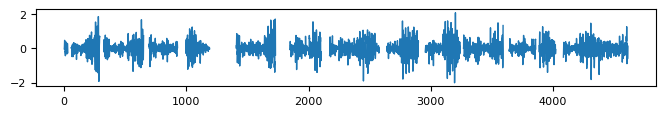

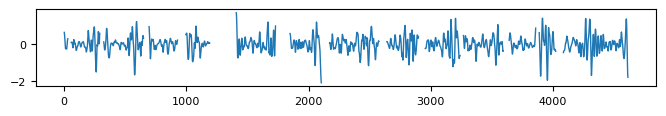

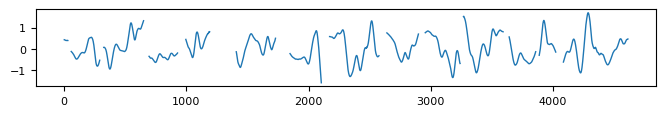

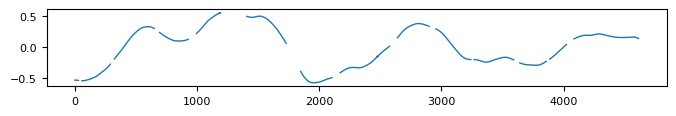

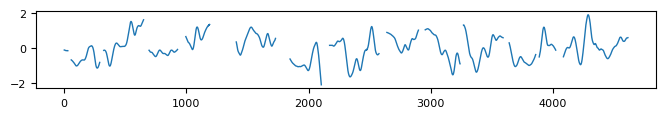

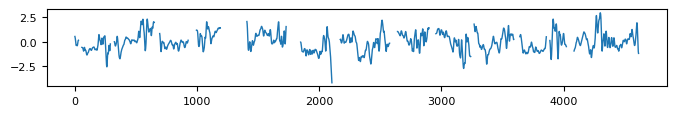

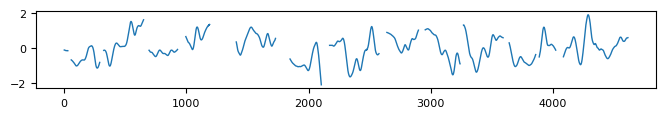

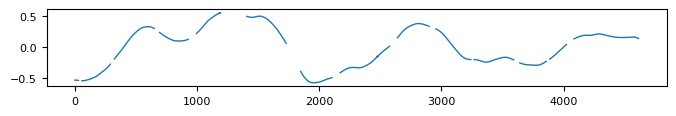

In [36]:
for el in np.arange(0,4):
    fig,ax=plt.subplots(1,1,figsize=(8,1))
    ax.plot(bxf['bando']['deseas'][el])

fig,ax=plt.subplots(1,1,figsize=(8,1))
ax.plot(bxf['bando']['deseas'][3]+bxf['bando']['deseas'][2])
fig,ax=plt.subplots(1,1,figsize=(8,1))
ax.plot(bxf['bxfilto']['deseas'][0])
fig,ax=plt.subplots(1,1,figsize=(8,1))
ax.plot(bxf['bxfilto']['deseas'][1])
fig,ax=plt.subplots(1,1,figsize=(8,1))
ax.plot(bxf['bxfilto']['deseas'][2])